In [1]:
# To do:
# import the new data (which you dont have right now)
# This code is copied from my worksttion and the data are also there. So if you want to run this, you need to import those data as well.

In [1]:
import sys
sys.path.append('/central/groups/astuart/hkaveh/QDYN/qdyn-read-only/src')  # For pyqdyn
import matplotlib.pyplot as plt
import numpy as np
from pyqdyn import qdyn
import ProcessFunctions
import matplotlib.font_manager
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from ProcessFunctions import FindMw


In [2]:
figsize = (9, 8)
def slip_profile(ox, warm_up=0, orientation="horizontal"):
    x_unique = ox["x"].unique()
    sort_inds = np.argsort(x_unique)
    x_unique = x_unique[sort_inds]
    t_vals = np.sort(ox["t"].unique())

    if warm_up > t_vals.max():
        print("Warm-up time > simulation time!")
        return

    ind_warmup = np.where(t_vals >= warm_up)[0][0]

    Nx = len(x_unique)
    Nt = len(t_vals) - 1

    slice = np.s_[Nx * ind_warmup:Nx * Nt]
    data_shape = (Nt - ind_warmup, Nx)
    x = ox["x"][slice].values.reshape(data_shape)[:, sort_inds]
    slip = ox["slip"][slice].values.reshape(data_shape)[:, sort_inds]
    v = ox["v"][slice].values.reshape(data_shape)[:, sort_inds]

    slip -= slip[0]
    t = t_vals[ind_warmup:-1]
    t -= t[0]

    fig = plt.figure(figsize=figsize)

    if orientation == "horizontal":
        CS = plt.contourf(x, slip, np.log10(v), levels=200, cmap="magma")
        plt.xlabel("position [m]")
        plt.ylabel("slip [m]")
        CB = plt.colorbar(CS, orientation="horizontal")
        CB.ax.set_title("slip rate [m/s]")
    elif orientation == "vertical":
        x -= x.min()
        CS = plt.contourf(slip, x * 1e-3, np.log10(v), levels=200, cmap="magma")
        plt.ylabel("depth [km]")
        plt.xlabel("slip [m]")
        plt.gca().invert_yaxis()
        CB = plt.colorbar(CS, orientation="horizontal")
        CB.ax.set_title("slip rate [m/s]")
    else:
        print("Keyword 'orientation=%s' not recognised" % orientation)
        plt.close()
        return
    plt.tight_layout()
    plt.show()

In [3]:
T_final = 1000
Ntout= 300
drs=0.006
t_yr = 3600 * 24 * 365.25   # seconds per 


In [6]:
# loading qdyn simulations
direct='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/2DSim_MainSimulation_Tf'+str(T_final)+"Nt="+str(Ntout)+"drs"+str(drs)+".pickle"
p=ProcessFunctions.ReadData(direct)


AttributeError: Can't get attribute '_unpickle_block' on <module 'pandas._libs.internals' from '/central/groups/astuart/hkaveh/soft/miniconda3/envs/learnmodel/lib/python3.7/site-packages/pandas/_libs/internals.cpython-37m-x86_64-linux-gnu.so'>

In [ ]:
# I cannot use this pickle file becuse of version problem

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


<Figure size 432x288 with 0 Axes>

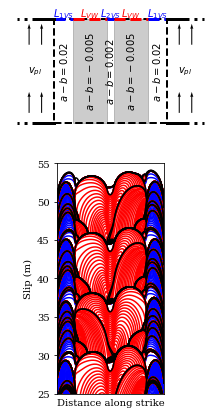

In [10]:
T_filter=400
v_thresh=1e-2
freq_plt_interevent=3*t_yr
freq_plt_event=3
# import slip

x_ox=p.ox["x"].unique() # Centering
Nx=len(x_ox)
Nt=len(p.ox["t"].unique())

# remove first T_filter years from V_ox, slip and t
t=p.ox["t"].values.reshape((Nt,len(x_ox)))
t=t[:,0]
index=np.argmin(np.abs(t-T_filter*t_yr))
t=t[index:]
V_ox=p.ox["v"].values.reshape((Nt,len(x_ox)))
V_ox=V_ox[index:,:]
vmax=np.max(V_ox,axis=1)
slip=p.ox["slip"].values.reshape((Nt,len(x_ox)))
slip=slip[index:,:]

interpolator = interp1d(t, slip, axis=0, kind='linear', fill_value='extrapolate')
Mw,T1,T2=FindMw(p, v_thresh,t_yr, T_filter)

slip_start=interpolator(T1)
slip_end=interpolator(T2)

# specifying the font and font size for the figures
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10
# specefing figure size
# specifying the height ratio in the figure
L1VS = 40
LVW  = 72.5
L2VS = 15
Total=  L1VS*2 + LVW*2 + L2VS
height_ratio = [.5, 1]
width_ratio=[1,.8]

figsize = (3.7, 7)
# Create figure
fig = plt.figure(figsize=figsize)

# Create GridSpec with 2 rows and 2 columns to control width and height ratios
gs = GridSpec(2, 3, figure=fig, width_ratios=[.35, 1,.35], height_ratios=[.5, 1])

ax1 = fig.add_subplot(gs[0, :])  # First subplot, first row, first column
ax2 = fig.add_subplot(gs[1, 1])  # Second subplot, second row, first column
ax=[ax1,ax2]


#ax.add_patch(plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.5))
ax[0].add_patch(plt.Rectangle((0, 0), 1, 1, alpha=1,edgecolor='black',facecolor='none',linewidth=2,linestyle='--')) 
ax[0].add_patch(plt.Rectangle((L1VS/Total, 0), LVW/Total, 1,edgecolor='black',facecolor='black',alpha=0.2)) 
ax[0].add_patch(plt.Rectangle(((L1VS+LVW+L2VS)/Total, 0), LVW/Total, 1,edgecolor='black',facecolor='black',alpha=0.2)) 

#ax[0].set_xlim([-.1, 1.1])
#ax[0].set_ylim([-.1, 1.1])
# removing x and y axis from the plot
# wrting text on the plot, rotate the text by 90 degree
ax[0].text(L1VS/Total/2, 0.5, r'$a-b=0.02$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((L1VS+LVW/2)/Total, 0.5, r'$a-b=- 0.005$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text(0.5, 0.5, r'$a-b=0.002$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((L1VS+LVW+L2VS+LVW/2)/Total, 0.5, r'$a-b=- 0.005$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((Total-L1VS/2)/Total, 0.5, r'$a-b=0.02$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text(L1VS/Total/2, 1.05, r'$L_{1VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')
ax[0].text((L1VS+LVW/2)/Total, 1.05, r'$L_{VW}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='red')
ax[0].text(0.5, 1.05, r'$L_{2VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')
ax[0].text((L1VS+LVW+L2VS+LVW/2)/Total, 1.05, r'$L_{VW}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='red')
ax[0].text((Total-L1VS/2)/Total, 1.05, r'$L_{1VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')

# plot a horizental line 
ax[0].plot([0,L1VS/Total], [1,1], color='blue', linewidth=3,linestyle='--')
ax[0].plot([L1VS/Total,(L1VS+LVW)/Total], [1,1], color='red', linewidth=3,linestyle='--')
ax[0].plot([(L1VS+LVW)/Total,(L1VS+LVW+L2VS)/Total], [1,1], color='blue', linewidth=3,linestyle='--')
ax[0].plot([(L1VS+LVW+L2VS)/Total,(Total-L1VS)/Total], [1,1], color='red', linewidth=3,linestyle='--')
ax[0].plot([(Total-L1VS)/Total,1], [1,1], color='blue', linewidth=3,linestyle='--')

ax[0].plot([1,1+L1VS/Total], [1,1], color='black', linewidth=3)
ax[0].plot([1,1+L1VS/Total], [0,0], color='black', linewidth=3)
ax[0].plot([0,0-L1VS/Total], [0,0], color='black', linewidth=3)
ax[0].plot([0,0-L1VS/Total], [1,1], color='black', linewidth=3)
ax[0].plot([1+L1VS/Total,1+2*L1VS/Total], [1,1], color='black', linewidth=3,linestyle=':')
ax[0].plot([1+L1VS/Total,1+2*L1VS/Total], [0,0], color='black', linewidth=3,linestyle=':')
ax[0].plot([-L1VS/Total,0-2*L1VS/Total], [0,0], color='black', linewidth=3,linestyle=':')
ax[0].plot([-L1VS/Total,0-2*L1VS/Total], [1,1], color='black', linewidth=3,linestyle=':')
uu=0
vv=0.2
ax[0].quiver([1+(4/3)*L1VS/Total], [0.75], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([1+(2/3)*L1VS/Total], [0.75], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([1+(4/3)*L1VS/Total], [0.1], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([1+(2/3)*L1VS/Total], [0.1], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)

ax[0].quiver([-(4/3)*L1VS/Total], [0.75], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([-(2/3)*L1VS/Total], [0.75], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([-(4/3)*L1VS/Total], [0.1], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)
ax[0].quiver([-(2/3)*L1VS/Total], [0.1], uu, vv, angles='xy', scale_units='xy', scale=1, color='black', width=0.005)

ax[0].text((Total+L1VS)/Total, .5, r'$v_{pl}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='black')
ax[0].text((0-L1VS)/Total, .5, r'$v_{pl}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='black')




ax[0].axis('off')

for i in range(T1.shape[0]-1): # not including everythin after the last event
    T_interevnt=np.arange(T2[i],T1[i+1],freq_plt_interevent) # from the end of the last event to the start of the next event
    T_event=np.arange(T1[i],T2[i],freq_plt_event) # from the start of the event to the end

    slip_interpolated_interevent = interpolator(T_interevnt)
    slip_interpolated_event=interpolator(T_event)

    for j in range(slip_interpolated_interevent.shape[0]):
        ax[1].plot(x_ox,slip_interpolated_interevent[j,:],color='b')
    for j in range(slip_interpolated_event.shape[0]):
        ax[1].plot(x_ox,slip_interpolated_event[j,:],color='r')

for j in range(slip_start.shape[0]):
    print(j)
    ax[1].plot(x_ox,slip_start[j,:],color='black')

for j in range(slip_end.shape[0]):
    ax[1].plot(x_ox,slip_end[j,:],color='black')

ax[1].set_xlabel('Distance along strike')
ax[1].set_ylabel('Slip (m)')
ax[1].set_xlim([x_ox[0],x_ox[-1]])

ax[1].set_xticks([])
ax[1].set_ylim(top=55,bottom=25)




# save figure
plt.savefig("./Figs/Geom2D_andSim.png", format='png', dpi=300)



In [ ]:

for i in range(T1.shape[0]-1): # not including everythin after the last event
    T_interevnt=np.arange(T2[i],T1[i+1],freq_plt_interevent) # from the end of the last event to the start of the next event
    T_event=np.arange(T1[i],T2[i],freq_plt_event) # from the start of the event to the end

    slip_interpolated_interevent = interpolator(T_interevnt)
    slip_interpolated_event=interpolator(T_event)

    for j in range(slip_interpolated_interevent.shape[0]):
        plt.plot(x_ox,slip_interpolated_interevent[j,:],color='b')
        plt.title('Slip evolution')
        plt.xlabel('x (m)')
        plt.ylabel('Slip (m)')
    for j in range(slip_interpolated_event.shape[0]):
        plt.plot(x_ox,slip_interpolated_event[j,:],color='r')
        plt.title('Slip evolution')
        plt.xlabel('x (m)')
        plt.ylabel('Slip (m)')
for j in range(slip_start.shape[0]):
    print(j)
    plt.plot(x_ox,slip_start[j,:],color='black')
    plt.title('Slip evolution')
    plt.xlabel('x (m)')
    plt.ylabel('Slip (m)')
for j in range(slip_end.shape[0]):
    plt.plot(x_ox,slip_end[j,:],color='black')
    plt.title('Slip evolution')
    plt.xlabel('x (m)')
    plt.ylabel('Slip (m)')

In [ ]:
# specifying the font and font size for the figures
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10
# specefing figure size
# specifying the height ratio in the figure
L1VS = 40
LVW  = 72.5
L2VS = 15
Total=  L1VS*2 + LVW*2 + L2VS
height_ratio = [.5, 1]


figsize = (3.7, 7)
fig, ax = plt.subplots(2,1,figsize=figsize,gridspec_kw={'height_ratios': height_ratio},constrained_layout=True)
#ax.add_patch(plt.Rectangle((0, 0), 1, 1, color='blue', alpha=0.5))
ax[0].add_patch(plt.Rectangle((0, 0), 1, 1, alpha=1,edgecolor='black',facecolor='none',linewidth=2)) 
ax[0].add_patch(plt.Rectangle((L1VS/Total, 0), LVW/Total, 1,edgecolor='black',facecolor='black',alpha=0.2)) 
ax[0].add_patch(plt.Rectangle(((L1VS+LVW+L2VS)/Total, 0), LVW/Total, 1,edgecolor='black',facecolor='black',alpha=0.2)) 

#ax[0].set_xlim([-.1, 1.1])
#ax[0].set_ylim([-.1, 1.1])
# removing x and y axis from the plot
# wrting text on the plot, rotate the text by 90 degree
ax[0].text(L1VS/Total/2, 0.5, r'$a-b=0.02$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((L1VS+LVW/2)/Total, 0.5, r'$a-b=- 0.005$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text(0.5, 0.5, r'$a-b=0.002$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((L1VS+LVW+L2VS+LVW/2)/Total, 0.5, r'$a-b=- 0.005$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text((Total-L1VS/2)/Total, 0.5, r'$a-b=0.02$', horizontalalignment='center', verticalalignment='center', fontsize=10, rotation=90)
ax[0].text(L1VS/Total/2, 1.05, r'$L_{1VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')
ax[0].text((L1VS+LVW/2)/Total, 1.05, r'$L_{VW}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='red')
ax[0].text(0.5, 1.05, r'$L_{2VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')
ax[0].text((L1VS+LVW+L2VS+LVW/2)/Total, 1.05, r'$L_{VW}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='red')
ax[0].text((Total-L1VS/2)/Total, 1.05, r'$L_{1VS}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='blue')
ax[0].text(-0.05, .5, r'$W_{2.5D}$', horizontalalignment='center', verticalalignment='center', fontsize=10,color='black',rotation=90)

# plot a horizental line 
ax[0].plot([0,L1VS/Total], [1,1], color='blue', linewidth=3)
ax[0].plot([L1VS/Total,(L1VS+LVW)/Total], [1,1], color='red', linewidth=3)
ax[0].plot([(L1VS+LVW)/Total,(L1VS+LVW+L2VS)/Total], [1,1], color='blue', linewidth=3)
ax[0].plot([(L1VS+LVW+L2VS)/Total,(Total-L1VS)/Total], [1,1], color='red', linewidth=3)
ax[0].plot([(Total-L1VS)/Total,1], [1,1], color='blue', linewidth=3)
ax[0].axis('off')

CS = ax[1].contourf(x, slip, np.log10(v), levels=200, cmap="inferno")

ax[1].set_xlabel("position (m)")
ax[1].set_ylabel("slip (m)")
CB = fig.colorbar(CS, ax=ax[1], orientation="horizontal",ticks=[0, -3,-6,-9,-12,-15])
CB.set_label("slip rate (m/s)")
# save figure
plt.savefig("./Figs/Geom2D_andSim.png", format='png', dpi=300)

